In [9]:
pip install numpy pandas torch matplotlib seaborn emoji nltk

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 586.9/586.9 kB 13.2 MB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
real_test = pd.read_csv("https://github.com/rrandev03/NLP_Final/raw/refs/heads/main/100_data/102_processed/real_testing_data.csv")
real_train = pd.read_csv('https://github.com/rrandev03/NLP_Final/raw/refs/heads/main/100_data/102_processed/real_training_data.csv')

In [12]:
pd.set_option("display.max_colwidth", None)

real_train.head()

Unnamed: 0        Date  \
0           0  2020-01-06   
1           1  2020-01-07   
2           2  2020-01-07   
3           3  2020-01-07   
4           4  2020-01-13   

                                                                                                                                                                                                                                                                            Tweet_Content  \
0                                                                                                                                                                                      Rivian Electric Vehicles To Offer Alexa Capability https://t.co/FldqbOdxHC https://t.co/WKBczVrNVn   
1                                                                                                                                   RenewOregon: Electric vehicles face an uncertain policy landscape in 2020 #ElectricVehicle via @axios https://t.co/Xp9eUOoGH6 https://t.co/bsuJMC09tJ   
2                                                                                                                                                             Really interesting chat about what‚Äôs going on with #transportation in San Francisco #micromobility  https://t.co/zUQQU8nm2e   
3              As consumers, we're used to a lot of things that make our lives easier with ICE cars. We can fill up practically anywhere, we know how they work, how they shift, we understand them. For electric vehicles, none of that is the same. #CES2020\n\nhttps://t.co/BWChozt9GJ   
4  With Model Y deliveries planned to begin this summer, our estimate is Tesla will deliver 506,000 electric vehicles in 2020 excl. SEMI. If Tesla grows sales at 20% a year after 2020 it could deliver 1.05 million vehicles in 2024.\nWhat year will Tesla reach 1 million deliveries?   

  Manual_Training_Labels  
0                NEUTRAL  
1                NEUTRAL  
2               POSITIVE  
3               NEGATIVE  
4                NEUTRAL

In [13]:
real_test.head()

Unnamed: 0        Date  \
0           0  2020-02-07   
1           1  2020-02-08   
2           2  2020-02-18   
3           3  2020-03-04   
4           4  2020-03-17   

                                                                                                                                                                                                                                                                                                         Tweet_Content  \
0      Find out why electric vehicles are a smart transportation choice and plug in to even more reasons to make the switch by visiting the Home, Garden &amp; Remodeling Show from Feb. 28 to March 1 and stop by the LG&amp;E and KU booth. Learn more at https://t.co/cc7JEBsLuU. #hgrs2020 https://t.co/PeFeRP9EOs   
1                                                                                                                                                                                                               How Soon Will Electric Vehicles Kill The Gasoline¬†Car? https://t.co/Nivn9TmVqA https://t.co/58DlNr2gyz   
2                                                                                                                                                            AI delivers a battery boost to electric vehicles, slashing testing times #98% #TechRepublic https://t.co/pV2gMmSRqm @TechRepublic https://t.co/DhuMNrxRuh   
3  There is so much anti-electric vehicles propaganda around, kids have started repeating it recently: ‚ÄúOh, EVs aren‚Äôt clean because of how batteries are made and how they're discarded"\n\nEp. 31 of #TheAngryCleanEnergyGuy podcast sets out what to do about it\n\nhttps://t.co/G5jXbcCqdF https://t.co/5Nv4ZbiEfl   
4                                                                                                 With the purchase of fully electric vehicles and the development of a tailor made Electric Government Vehicles(EGV) course, PROCentrum Driving is proudly the first professional European trainer in this new field.   

  Manual_Testing_Labels  
0              POSITIVE  
1               NEUTRAL  
2               NEUTRAL  
3              POSITIVE  
4               NEUTRAL

In [14]:
train_df = real_train[['Tweet_Content', 'Manual_Training_Labels']]
test_df = real_test[['Tweet_Content', 'Manual_Testing_Labels']]

Data Pre Processing

In [15]:
import re, string
import emoji
import nltk

In [16]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.replace_emoji(text, replace='')  # Remove emoji by replacing them with an empty string

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + '√É'+'¬±'+'√£'+'¬º'+'√¢'+'¬ª'+'¬ß'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [17]:
texts_new = []
for t in train_df.Tweet_Content:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

train_df['Cleaned_Tweets'] = texts_new
train_df.head()

<ipython-input-17-95793eb7b57c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Cleaned_Tweets'] = texts_new


Tweet_Content  \
0                                                                                                                                                                                      Rivian Electric Vehicles To Offer Alexa Capability https://t.co/FldqbOdxHC https://t.co/WKBczVrNVn   
1                                                                                                                                   RenewOregon: Electric vehicles face an uncertain policy landscape in 2020 #ElectricVehicle via @axios https://t.co/Xp9eUOoGH6 https://t.co/bsuJMC09tJ   
2                                                                                                                                                             Really interesting chat about what‚Äôs going on with #transportation in San Francisco #micromobility  https://t.co/zUQQU8nm2e   
3              As consumers, we're used to a lot of things that make our lives easier with ICE cars. We can fill up practically anywhere, we know how they work, how they shift, we understand them. For electric vehicles, none of that is the same. #CES2020\n\nhttps://t.co/BWChozt9GJ   
4  With Model Y deliveries planned to begin this summer, our estimate is Tesla will deliver 506,000 electric vehicles in 2020 excl. SEMI. If Tesla grows sales at 20% a year after 2020 it could deliver 1.05 million vehicles in 2024.\nWhat year will Tesla reach 1 million deliveries?   

  Manual_Training_Labels  \
0                NEUTRAL   
1                NEUTRAL   
2               POSITIVE   
3               NEGATIVE   
4                NEUTRAL   

                                                                                                                                                                                                                                                                  Cleaned_Tweets  
0                                                                                                                                                                                                                             rivian electric vehicles to offer alexa capability  
1                                                                                                                                                                                   reneworegon electric vehicles face an uncertain policy landscape in 2020 electricvehicle via  
2                                                                                                                                                                                really interesting chat about whats going on with transportation in san francisco micromobility  
3                                          as consumers were used to a lot of things that make our lives easier with ice cars we can fill up practically anywhere we know how they work how they shift we understand them for electric vehicles none of that is the same ces2020  
4  with model y deliveries planned to begin this summer our estimate is tesla will deliver 506000 electric vehicles in 2020 excl semi if tesla grows sales at 20 a year after 2020 it could deliver 105 million vehicles in 2024 what year will tesla reach 1 million deliveries

In [18]:
texts_new = []
for t in test_df.Tweet_Content:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

test_df['Cleaned_Tweets'] = texts_new
test_df.head()

<ipython-input-18-873a2fd04426>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Cleaned_Tweets'] = texts_new


Tweet_Content  \
0      Find out why electric vehicles are a smart transportation choice and plug in to even more reasons to make the switch by visiting the Home, Garden &amp; Remodeling Show from Feb. 28 to March 1 and stop by the LG&amp;E and KU booth. Learn more at https://t.co/cc7JEBsLuU. #hgrs2020 https://t.co/PeFeRP9EOs   
1                                                                                                                                                                                                               How Soon Will Electric Vehicles Kill The Gasoline¬†Car? https://t.co/Nivn9TmVqA https://t.co/58DlNr2gyz   
2                                                                                                                                                            AI delivers a battery boost to electric vehicles, slashing testing times #98% #TechRepublic https://t.co/pV2gMmSRqm @TechRepublic https://t.co/DhuMNrxRuh   
3  There is so much anti-electric vehicles propaganda around, kids have started repeating it recently: ‚ÄúOh, EVs aren‚Äôt clean because of how batteries are made and how they're discarded"\n\nEp. 31 of #TheAngryCleanEnergyGuy podcast sets out what to do about it\n\nhttps://t.co/G5jXbcCqdF https://t.co/5Nv4ZbiEfl   
4                                                                                                 With the purchase of fully electric vehicles and the development of a tailor made Electric Government Vehicles(EGV) course, PROCentrum Driving is proudly the first professional European trainer in this new field.   

  Manual_Testing_Labels  \
0              POSITIVE   
1               NEUTRAL   
2               NEUTRAL   
3              POSITIVE   
4               NEUTRAL   

                                                                                                                                                                                                                                           Cleaned_Tweets  
0  find out why electric vehicles are a smart transportation choice and plug in to even more reasons to make the switch by visiting the home garden amp remodeling show from feb 28 to march 1 and stop by the lgampe and ku booth learn more at hgrs2020  
1                                                                                                                                                                                                    how soon will electric vehicles kill the gasolinecar  
2                                                                                                                                                                 ai delivers a battery boost to electric vehicles slashing testing times 98 techrepublic  
3     there is so much antielectric vehicles propaganda around kids have started repeating it recently oh evs arent clean because of how batteries are made and how theyre discarded ep 31 of theangrycleanenergyguy podcast sets out what to do about it  
4                                        with the purchase of fully electric vehicles and the development of a tailor made electric government vehiclesegv course procentrum driving is proudly the first professional european trainer in this new field

Importing Transformers

In [19]:
#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

In [20]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

token_lens = []

for txt in train_df['Cleaned_Tweets'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)
print(f"MAX TOKENIZED SENTENCE LENGTH FOR TRAINING DATA: {max_len}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

MAX TOKENIZED SENTENCE LENGTH FOR TRAINING DATA: 64


In [21]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [22]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

token_lens = []

for txt in test_df['Cleaned_Tweets'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)
print(f"MAX TOKENIZED SENTENCE LENGTH FOR TESTING DATA: {max_len}")

MAX TOKENIZED SENTENCE LENGTH FOR TESTING DATA: 66


In [23]:
test_df = test_df.sample(frac=1).reset_index(drop=True)

Tweet Label Column Analysis

In [24]:
train_df['Manual_Training_Labels'].value_counts()


Manual_Training_Labels
NEUTRAL      101
POSITIVE      52
NEGATIVE      29
POSITIVE      10
NEGATIVE       7
NEGTIVE        1
Name: count, dtype: int64

In [25]:
train_df.loc[train_df['Manual_Training_Labels'] == 'NEGTIVE', 'Manual_Training_Labels'] = 'NEGATIVE'
train_df['Manual_Training_Labels'] = train_df['Manual_Training_Labels'].str.strip()


In [26]:
train_df['Manual_Training_Labels'].value_counts()


Manual_Training_Labels
NEUTRAL     101
POSITIVE     62
NEGATIVE     37
Name: count, dtype: int64

In [27]:
train_df['Sentiment'] = train_df['Manual_Training_Labels'].map({'NEGATIVE':0,'NEUTRAL':1,'POSITIVE':2})
train_df

Tweet_Content  \
0                                                                                                                                                       Electric Vehicles\n\nWhat could be under the 300M and 700M vehicle categories?\n\nConfigurable van + affordable EV? https://t.co/iD27gyXg6H   
1                                                   Get The Facts on Electric Vehicles. Tonight on #WGAL News 8 at six, we begin a week-long series - Charged. What electric vehicles will mean for our roads, taxes, safety and lifestyle. 8 On Your Side has the answers. https://t.co/6RE8MRqWkK   
2                 Governments will play a huge part in moving drivers towards #EVs. Many have already set firm dates for banning new sales of ICE vehicles. And #COP26 will put even more pressure on policy makers to accelerate the phase-out üëá \nhttps://t.co/0uzyMIR8q8 https://t.co/ZJv46CxRMF   
3    This is unreal. Biden and the White House shunned Tesla on its 'EV Day' at the behest of UAW. \n\nNow UAW is trying to block the USA's transition to EVs. \n\nUAW President cited concerns over what they EVs would look like and impact their membership\n\n$tsla \n\nhttps://t.co/CNWxrtYrQf   
4                                                                             Beside Jamie-Lynn Spears crazy cat killing ass electric cars are too quiet. Blind people don't hear when they cross the street. \nEurope requires electric vehicles to make some sound now. \nhttps://t.co/O7z79CsfDe   
..                                                                                                                                                                                                                                                                                              ...   
195                                                                                                                                                                               Does the world have enough lithium to move to electric vehicles?\nhttps://t.co/gCay8Sb1v3 https://t.co/5UJ244gPpR   
196                                                                      Tip: Stop buying electric vehicles and they stop building them, along with the charging stations to replace fuel and eventually flip the country to "electric everything" so they can cut you off with a flip of a switch.   
197                                                                                                                          Tesla CEO Elon Musk has given employees of his electric vehicle company a choice: return to in-person work for 40 hours per week or resign.\n\nhttps://t.co/BmFMXejfJO   
198                                       Unfortunately, the fantasy of widespread, uniform electric vehicle use is at odds with the reality of these machines. \nAfter mass rain and floods, several electric vehicles across the Sunshine State are literally exploding.\nhttps://t.co/SAGmHr0OGU   
199      Improving #AirQuality is vital to operations at @portofstockton. Implementing practices such as transitioning to electric vehicles and equipment, to requiring docked vessels to shut off their engines are just some of the many ways the Port reduces emissions. https://t.co/9Zargm1SmF   

    Manual_Training_Labels  \
0                  NEUTRAL   
1                  NEUTRAL   
2                  NEUTRAL   
3                  NEUTRAL   
4                 NEGATIVE   
..                     ...   
195                NEUTRAL   
196               NEGATIVE   
197               NEGATIVE   
198               NEGATIVE   
199                NEUTRAL   

                                                                                                                                                                                                                                       Cleaned_Tweets  \
0                                                                                                                           

In [28]:
test_df['Manual_Testing_Labels'].value_counts()


Manual_Testing_Labels
NEUTRAL      52
POSITIVE     27
NEGATIVE     16
NEGATIVE      4
POSITIVE      3
NEUTRAL       1
Name: count, dtype: int64

In [29]:
test_df['Manual_Testing_Labels'] = test_df['Manual_Testing_Labels'].str.strip()


In [30]:
test_df['Manual_Testing_Labels'].value_counts()


Manual_Testing_Labels
NEUTRAL     53
POSITIVE    30
NEGATIVE    20
Name: count, dtype: int64

In [31]:
test_df['Sentiment'] = test_df['Manual_Testing_Labels'].map({'NEGATIVE':0,'NEUTRAL':1,'POSITIVE':2})
test_df

Tweet_Content  \
0      Tesla's secret new 'million mile' battery: #Tesla plans to introduce a new low-cost, long-life battery in its #Model3 in China within a year that will bring the cost of electric vehicles in line with gas cars &amp; allow EV batteries to have 2nd life in the electric power grid #EV https://t.co/CzLQUzi0Ag   
1                                                                                                                                                                                      YELLEN SAYS CLIMATE CHANGE POSES EXISTENTIAL THREAT, REQUIRES INVESTMENT IN CLEAN TECHNOLOGY, RENEWABLE ENERGY, ELECTRIC VEHICLES   
2                                                                                                                                                                                                              Rivian has now produced just over 1,000 electric vehicles https://t.co/AIr5AJ6WMh https://t.co/mzahC63VyP   
3                                                                                                                                                                                                          Tesla delivers 88,400 electric vehicles, beating expectations https://t.co/85MVf85CZH https://t.co/p52LM1IOJW   
4    There is so much anti-electric vehicles propaganda around, kids have started repeating it recently: ‚ÄúOh, EVs aren‚Äôt clean because of how batteries are made and how they're discarded"\n\nEp. 31 of #TheAngryCleanEnergyGuy podcast sets out what to do about it\n\nhttps://t.co/G5jXbcCqdF https://t.co/5Nv4ZbiEfl   
..                                                                                                                                                                                                                                                                                                                   ...   
98                                                                        Clean mobility will be the future of transportation. Electric Vehicles are currently the most viable option of clean mobility and they are fueled by electricity which eliminates emissions. \nhttps://t.co/8ZkuSxLimw https://t.co/Lhf7SHTCXd   
99                                                                                Electric vehicle gets towed to charging station because it ran out of juice during live @FoxNews broadcast.\n\nSegment was discussing how Democrats are trying to convince you rubes to buy electric vehicles. https://t.co/0h3NXF40sB   
100                                                                                                                                          I honestly think every Californian needs to buy a human sized hamster wheel in order to charge all their forthcoming electric vehicles. Only way I can see this going well.   
101                                                                                                                      Thank you, @POTUS for getting US supercharging EV industry as this is future!! It doesn‚Äôt matter how much @GOP fights for Big Oil, our Climate depends on everyone going to Electric Vehicles!!   
102                                           A recent price drop for Tesla‚Äôs (@Tesla) Model 3 and Model Y electric vehicles have made the cars eligible again for a California EV rebate, and now the incentive program is quickly running out of money.\n‚úèÔ∏è: Elaine Goodman\n#EnergyTwitter #EnergyMarkets #EnergyNews   

    Manual_Testing_Labels  \
0                 NEUTRAL   
1                NEGATIVE   
2                 NEUTRAL   
3                 NEUTRAL   
4                POSITIVE   
..                    ...   
98               POSITIVE   
99               NEGATIVE   
100              NEGATIVE   
101              POSITIVE   
102               NEUTRAL   

                                                                                                                                                 

Class Balancing by RandomOverSampler


In [32]:
len(train_df)

200

In [33]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(train_df['Cleaned_Tweets']).reshape(-1, 1), np.array(train_df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['Cleaned_Tweets', 'Sentiment']);

In [34]:
train_os['Sentiment'].value_counts()

Sentiment
1    101
0    101
2    101
Name: count, dtype: int64

Train-Validation-Test

In [35]:
#from sklearn.model_selection import train_test_split

#X_train, X_valid, y_train, y_valid = train_test_split(train_os['Cleaned_Tweets'], train_os['Sentiment'], test_size=0.2, random_state=42)

In [ ]:
X_train = train_os(['Cleaned_Tweets'])
y_train = train_os(['Sentiment'])

In [36]:
X_test = test_df['Cleaned_Tweets']
y_test = test_df['Sentiment']

One Hot Encoding

In [37]:
y_train_spare = y_train.copy()
#y_valid_spaer = y_valid.copy()
y_test_spare = y_test.copy()

In [38]:
from sklearn import preprocessing

ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
#y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

BERT Sentiment Analysis

In [39]:
X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
#X_valid = X_valid.reset_index(drop=True)
# y_valid = y_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)

In [40]:
MAX_LEN=128

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [41]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
#val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [42]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [43]:
import tensorflow as tf

In [44]:
def create_model(bert_model, max_len=MAX_LEN):

    ##params###
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-6,
    decay_steps=10000,
    decay_rate=0.9)
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    loss = tf.keras.losses.CategoricalCrossentropy()
    #accuracy = tf.keras.metrics.CategoricalAccuracy() change this to f1 score
#make training 240 and 60 for testing
#get rid of validation set
#stratified cross validation



    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)
    return model


In [45]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [46]:
len(X_train)

242

In [47]:
len(X_test)

103

In [48]:
bert_history = model.fit([train_input_ids, train_attention_masks], y_train, epochs=20, batch_size=5)

Epoch 1/20
49/49 [==============================] - 50s 260ms/step - loss: 1.1204 - categorical_accuracy: 0.3223 - val_loss: 1.0479 - val_categorical_accuracy: 0.4262
Epoch 2/20
49/49 [==============================] - 9s 183ms/step - loss: 1.0717 - categorical_accuracy: 0.4380 - val_loss: 1.0261 - val_categorical_accuracy: 0.5410
Epoch 3/20
49/49 [==============================] - 9s 182ms/step - loss: 1.0314 - categorical_accuracy: 0.5537 - val_loss: 0.9963 - val_categorical_accuracy: 0.6066
Epoch 4/20
49/49 [==============================] - 9s 188ms/step - loss: 0.9747 - categorical_accuracy: 0.5992 - val_loss: 0.9572 - val_categorical_accuracy: 0.6721
Epoch 5/20
49/49 [==============================] - 9s 186ms/step - loss: 0.9357 - categorical_accuracy: 0.6364 - val_loss: 0.9047 - val_categorical_accuracy: 0.7049
Epoch 6/20
49/49 [==============================] - 9s 182ms/step - loss: 0.8560 - categorical_accuracy: 0.7025 - val_loss: 0.8510 - val_categorical_accuracy: 0.6721
Epo

Test data

In [49]:
results = model.predict([test_input_ids, test_attention_masks])

4/4 [==============================] - 3s 208ms/step


In [50]:
results

array([[0.01289818, 0.90631443, 0.0807874 ],
       [0.08256078, 0.8172666 , 0.10017265],
       [0.06495153, 0.8390331 , 0.09601531],
       [0.04005917, 0.9156727 , 0.04426804],
       [0.30329126, 0.3214936 , 0.37521517],
       [0.02050518, 0.44615862, 0.53333616],
       [0.0250553 , 0.7563088 , 0.21863595],
       [0.5067083 , 0.3288613 , 0.16443042],
       [0.13464561, 0.27433196, 0.59102243],
       [0.07118514, 0.5286745 , 0.40014035],
       [0.6880349 , 0.12692252, 0.1850426 ],
       [0.5217325 , 0.22723511, 0.25103244],
       [0.35214218, 0.4256472 , 0.22221057],
       [0.03035529, 0.7803111 , 0.18933356],
       [0.03642714, 0.8435765 , 0.11999638],
       [0.03024657, 0.17991099, 0.78984237],
       [0.10104433, 0.36472875, 0.53422695],
       [0.03425038, 0.7322663 , 0.2334833 ],
       [0.0665143 , 0.46028087, 0.47320482],
       [0.25003275, 0.4127116 , 0.3372557 ],
       [0.15401274, 0.48115036, 0.3648369 ],
       [0.02585098, 0.61839867, 0.35575035],
       [0.

In [51]:
y_pred = np.zeros_like(results)
y_pred[np.arange(len(y_pred)), results.argmax(1)] = 1
y_pred

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0

In [52]:
y_test

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1

              precision    recall  f1-score   support

           0       0.53      0.40      0.46        20
           1       0.70      0.66      0.68        53
           2       0.55      0.70      0.62        30

    accuracy                           0.62       103
   macro avg       0.60      0.59      0.58       103
weighted avg       0.62      0.62      0.62       103



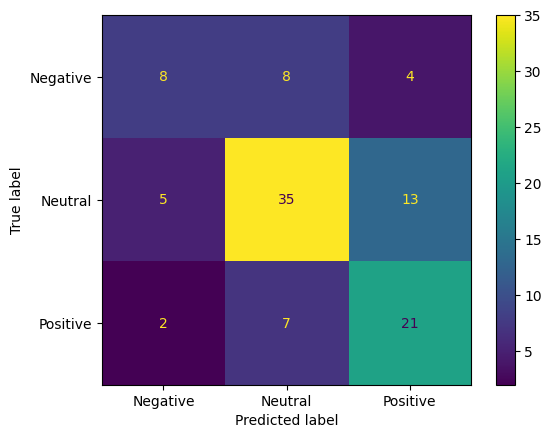

In [54]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

print(classification_report(y_test.argmax(1), y_pred.argmax(1)))
cm  = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()
plt.show()
